# **View a specific instance and test correctness of features**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from scipy.spatial.distance import cdist
import gurobipy as gp
from gurobipy import GRB
from scipy.stats import skew
import math
import itertools
from sklearn.cluster import DBSCAN

# Load functions
from data_gen_functions import distance, fun_load_file, solve_tsp, solve_cvrp, plot_instance, fun_cluster_features

# Assign string "TSP" or "CVRP" to the following variable to define the routing problem
optimization_problem = "CVRP"

# Get the name of the folder and the file name
if (optimization_problem == "TSP"):
    folder = "01_TSP"
    file_name = "tsp_instances_j_updated.xlsx"
elif (optimization_problem == "CVRP"):
    folder = "02_CVRP"
    file_name = "cvrp_instances_j_updated.xlsx"

# Load data
df_final = fun_load_file(subfolder_path="..\\..\\01_data\\" + folder, name=file_name)
df_final = df_final[df_final.columns[1:]]
df_final

,Instance ID,Number Customers,X,Y,Vehicle Capacity,Demand,Total Demand,X Depot,Y Depot,Depot Distance,...,Distance To Closest Other Cluster Ratio,Distance To Closest Other Centroid Ratio,Cluster Area Ratio,Cluster Density Ratio,Savings Ratio,Marginal Cost Ratio,Demand Ratio,Cluster Demand Ratio,Cluster Demand Proportion Ratio,Shapley Value
0,1,5,86.027966,95.446677,16,5,19,29.551338,5.437034,106.260742,...,1.064303,1.053179,1.635119,0.101892,0.642218,1.225720,1.315789,1.122449,1.136364,85.337134
1,1,5,92.299886,89.092199,16,2,19,29.551338,5.437034,104.573261,...,1.016669,1.008670,1.635119,0.101892,1.310010,0.167169,0.526316,1.122449,0.454545,72.157370
2,1,5,61.404822,7.793238,16,4,19,29.551338,5.437034,31.940509,...,0.957786,0.970516,0.047321,2.347162,1.796135,1.159858,1.052632,0.816327,1.250000,30.779912
3,1,5,57.101808,4.267994,16,4,19,29.551338,5.437034,27.575262,...,1.003456,1.021359,0.047321,2.347162,0.216634,1.171411,1.052632,0.816327,1.250000,28.850226
4,1,5,67.005710,89.535835,16,4,19,29.551338,5.437034,92.062143,...,0.957786,0.946276,1.635119,0.101892,1.035002,1.275842,1.052632,1.122449,0.909091,73.437048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101995,12000,12,62.573873,51.000100,14,4,41,91.032404,49.408248,28.503018,...,0.744415,0.607843,0.618233,1.103139,0.053880,0.457787,1.170732,0.878049,1.333333,23.357590
101996,12000,12,90.838056,93.465110,14,4,41,91.032404,49.408248,44.057291,...,1.298501,1.255435,1.940459,0.351462,2.232051,1.405690,1.170732,0.878049,1.333333,60.120348
101997,12000,12,14.800099,38.550679,14,5,41,91.032404,49.408248,77.001631,...,1.116170,1.093645,0.441308,1.545399,3.233204,1.872386,1.463415,1.243902,1.176471,72.730610
101998,12000,12,66.502247,28.687865,14,5,41,91.032404,49.408248,32.110168,...,0.977961,0.947355,0.618233,1.103139,1.679350,0.658557,1.463415,0.878049,1.666667,32.926985


**Extract necessary information out of the instance**

In [2]:
# Define instance id and get the data frame of the instance
instance_id = 1
instance_df = df_final[df_final["Instance ID"] == instance_id]
instance_df.index = np.arange(start=1, stop=len(instance_df)+1)

# Get instance coordinates and cluster assignments
coord = [(instance_df.iloc[0]["X Depot"], instance_df.iloc[0]["Y Depot"])] + [(instance_df.iloc[i]["X"], instance_df.iloc[i]["Y"]) for i in range(len(instance_df))]
assignments = instance_df["Cluster"]

# Get indices of core points
core_points_mask = np.zeros_like(assignments, dtype=bool) # Create list with same length as assignments containing only zero/False values
core_point_indices = np.where(instance_df["Core Point"] == True)[0]

# Solve the instance
sequence, total_cost = solve_tsp(coord)

if (optimization_problem == "TSP"): sequence, total_cost = solve_tsp(coord)

elif (optimization_problem == "CVRP"):
    # Get the demands and the capacity first
    demands = [0] + list(instance_df["Demand"])
    capacity = list(instance_df["Vehicle Capacity"])[0]
    sequence, total_cost = solve_cvrp(coord, demands, capacity)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-04


**Distance features**

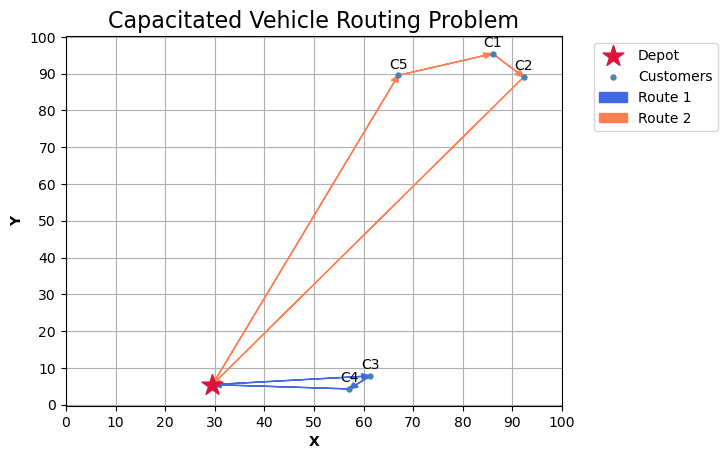

,Instance ID,Number Customers,X,Y,Vehicle Capacity,Demand,Total Demand,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,4th CCD,5th CCD,6th CCD,7th CCD,8th CCD,9th CCD,10th CCD,Mean Distance To Other Customers,Gravity Center Distance
1,1,5,86.027966,95.446677,16,5,19,106.260742,8.928403,19.919445,91.046278,95.657070,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,53.887799,40.454357
2,1,5,92.299886,89.092199,16,2,19,104.573261,8.928403,25.298066,86.971410,91.837087,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,53.258742,37.374751
3,1,5,61.404822,7.793238,16,4,19,31.940509,5.562668,81.934255,86.971410,91.046278,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,66.378653,50.723152
4,1,5,57.101808,4.267994,16,4,19,27.575262,5.562668,85.841086,91.837087,95.657070,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,69.724478,55.227775
5,1,5,67.005710,89.535835,16,4,19,92.062143,19.919445,25.298066,81.934255,85.841086,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,53.248213,32.818486


Depot distances:


{'Customer 1': 106.26074224503367,
 'Customer 2': 104.57326105303329,
 'Customer 3': 31.940509071521852,
 'Customer 4': 27.575261584208544,
 'Customer 5': 92.06214312472899}

CLOSEST CUSTOMER DISTANCES:
- Customer 1: [ 8.92840276 19.91944459 91.04627781 95.65706971]; Mean: 53.887798718869206
- Customer 2: [ 8.92840276 25.2980661  86.97140997 91.83708717]; Mean: 53.258741500360806
- Customer 3: [ 5.56266787 81.93425459 86.97140997 91.04627781]; Mean: 66.37865256017855
- Customer 4: [ 5.56266787 85.84108558 91.83708717 95.65706971]; Mean: 69.72447758382339
- Customer 5: [19.91944459 25.2980661  81.93425459 85.84108558]; Mean: 53.24821271541858

Gravity Center: [72.76803858760505, 57.227188527004955]

CUSTOMER DISTANCE MATRIX:


,Customer 1,Customer 2,Customer 3,Customer 4,Customer 5,Mean,Gravity Center Distance
Customer 1,0.000000,8.928403,91.046278,95.657070,19.919445,53.887799,40.454357
Customer 2,8.928403,0.000000,86.971410,91.837087,25.298066,53.258742,37.374751
Customer 3,91.046278,86.971410,0.000000,5.562668,81.934255,66.378653,50.723152
Customer 4,95.657070,91.837087,5.562668,0.000000,85.841086,69.724478,55.227775
Customer 5,19.919445,25.298066,81.934255,85.841086,0.000000,53.248213,32.818486


In [3]:
# Get column names
instance_features = ["Instance ID", "Number Customers", "X", "Y", "X Depot", "Y Depot"]
if (optimization_problem == "CVRP"): instance_features[4:4] = ["Vehicle Capacity", "Demand", "Total Demand"] # Insert these columns at location 4

distance_features = ["Depot Distance", "Closest Customer Distance (CCD)", "2nd CCD", "3rd CCD", "4th CCD", "5th CCD", "6th CCD", 
                     "7th CCD", "8th CCD", "9th CCD", "10th CCD", "Mean Distance To Other Customers", "Gravity Center Distance"]

# Define the range for X and Y coordinates and view instance with optimal tour as well as the data frame
x_range = (0, 100)
y_range = (0, 100)
plot_instance(coord=coord, sequence=sequence, total_cost=total_cost, x_range=x_range, y_range=y_range, optimization_problem=optimization_problem, 
              assignments=None, core_point_indices=None, plot_sequence=True)
display(instance_df[instance_features[:7] + distance_features])

# Depot distances
num_customers = len(instance_df)
print("Depot distances:")
display({"Customer " + str(i): distance(coord1=coord[0], coord2=coord[i]) for i in range(1, num_customers+1)})

# Customer distance matrix and mean distance
labels = ["Customer " + str(i) for i in range(1, num_customers+1)]
distance_matrix = pd.DataFrame(cdist(instance_df[["X", "Y"]], instance_df[["X", "Y"]], metric="euclidean"), index=labels, columns=labels)
for index in range(len(distance_matrix)):
    if (index == 0): print("CLOSEST CUSTOMER DISTANCES:")
    print("- Customer {}: {}; Mean: {}".format(index+1, np.sort(distance_matrix.iloc[index])[1:min(num_customers, 11)], np.mean(np.sort(distance_matrix.iloc[index])[1:])))
distance_matrix["Mean"] = np.sum(distance_matrix, axis=1) / (num_customers - 1)

# Add gravity center
gravity_center = list(np.mean(instance_df[["X", "Y"]], axis=0))
print("\nGravity Center:", gravity_center)
gravity_center_distances = [distance(coord1=gravity_center, coord2=list(instance_df.iloc[customer][["X", "Y"]])) for customer in range(num_customers)]
distance_matrix["Gravity Center Distance"] = gravity_center_distances

print("\nCUSTOMER DISTANCE MATRIX:"); display(distance_matrix)

**Cluster features**

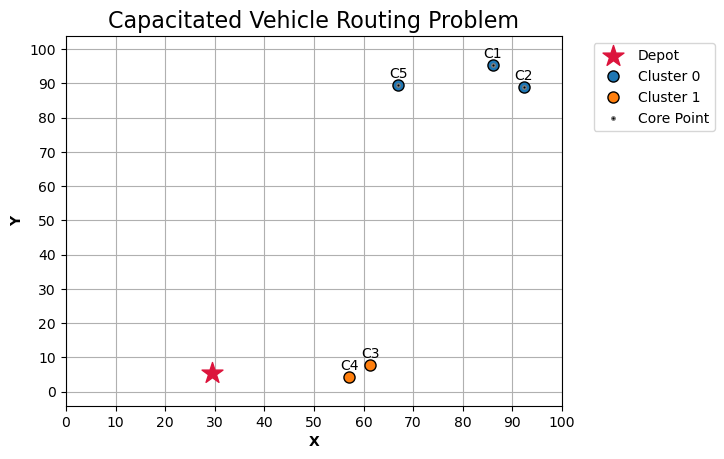

,X,Y,Vehicle Capacity,Demand,Cluster,Core Point,Outlier,Number Clusters,Number Outliers,Cluster Size,X Centroid,Y Centroid,Centroid Distance,Centroid Distance To Depot,Distance To Closest Other Cluster,Distance To Closest Other Centroid,Cluster Area,Cluster Density,Cluster Demand,Cluster Demand Proportion
1,86.027966,95.446677,16,5,0,1,0,2,0,3,81.777854,91.358237,5.897355,100.548804,91.046278,93.338706,502.494082,0.005970,11,0.454545
2,92.299886,89.092199,16,2,0,1,0,2,0,3,81.777854,91.358237,10.763275,100.548804,86.971410,89.394086,502.494082,0.005970,11,0.181818
3,61.404822,7.793238,16,4,1,0,0,2,0,2,59.253315,6.030616,2.781334,29.707907,81.934255,86.012613,14.542375,0.137529,8,0.500000
4,57.101808,4.267994,16,4,1,0,0,2,0,2,59.253315,6.030616,2.781334,29.707907,85.841086,90.518604,14.542375,0.137529,8,0.500000
5,67.005710,89.535835,16,4,0,1,0,2,0,3,81.777854,91.358237,14.884132,100.548804,81.934255,83.864302,502.494082,0.005970,11,0.363636


Cluster 0 with Customers: [1, 2, 5]
    - Centroid {'X': 81.7778543022459, 'Y': 91.35823707408947}
    - Customer distances to centorid: [5.897354861810874, 10.763274878430959, 14.884131992478865]
    - Centroid distance to depot: 100.5488044033097
    - Distance of other cluster customers to centroid: {'Customer 3': 86.01261276832088, 'Customer 4': 90.51860448741535}
Cluster 1 with Customers: [3, 4]
    - Centroid {'X': 59.25331501564376, 'Y': 6.030615706378189}
    - Customer distances to centorid: [2.781333932835114, 2.781333932835113]
    - Centroid distance to depot: 29.707907485159716
    - Distance of other cluster customers to centroid: {'Customer 1': 93.33870593834617, 'Customer 2': 89.39408564551532, 'Customer 5': 83.86430233440856}

CUSTOMER DISTANCE MATRIX:


,Customer 1,Customer 2,Customer 3,Customer 4,Customer 5,Mean,Gravity Center Distance
Customer 1,0.000000,8.928403,91.046278,95.657070,19.919445,53.887799,40.454357
Customer 2,8.928403,0.000000,86.971410,91.837087,25.298066,53.258742,37.374751
Customer 3,91.046278,86.971410,0.000000,5.562668,81.934255,66.378653,50.723152
Customer 4,95.657070,91.837087,5.562668,0.000000,85.841086,69.724478,55.227775
Customer 5,19.919445,25.298066,81.934255,85.841086,0.000000,53.248213,32.818486


In [4]:
# Get column names
cluster_features = ["Cluster", "Core Point", "Outlier", "Number Clusters", "Number Outliers", "Cluster Size", "X Centroid", "Y Centroid", "Centroid Distance", 
                    "Centroid Distance To Depot", "Distance To Closest Other Cluster", "Distance To Closest Other Centroid", "Cluster Area", "Cluster Density"]
if (optimization_problem == "CVRP"): cluster_features += ["Cluster Demand", "Cluster Demand Proportion"]

# View instance as well as the data frame
plot_instance(coord=coord, sequence=None, total_cost=None, x_range=x_range, y_range=y_range, optimization_problem=optimization_problem,
              assignments=assignments, core_point_indices=core_point_indices, plot_sequence=False)
display(instance_df[instance_features[2:6] + cluster_features])

# Recompute cluster features
for cluster in np.unique(instance_df["Cluster"]):
    if (cluster == -1):
        # Compute feature for each outlier individually
        for outlier in instance_df[instance_df["Cluster"] == -1].index:
            cluster_data = centroid = list(instance_df.loc[outlier][["X", "Y"]])
            centroid_distances = distance(coord1=centroid, coord2=cluster_data)
            centroid_depot_distance = distance(coord1=centroid, coord2=coord[0])
            not_cluster_data = instance_df[instance_df["Cluster"] != cluster][["X", "Y"]]
            other_customers_centroid_distances = [distance(coord1=centroid, coord2=list(not_cluster_data.iloc[customer])) for customer in range(len(not_cluster_data))]

            # Print results
            print("Cluster {}: Customer {}\n    - Centroid {}".format(int(cluster), outlier, {"X": centroid[0], "Y": centroid[1]}))
            print("    - Customer distances to centorid: {}\n    - Centroid distance to depot: {}".format(centroid_distances, centroid_depot_distance))
            #print("    - Distance of other cluster customers to centroid:", other_customers_centroid_distances)
    
    else: # Compute features for all other clusters
        cluster_data = instance_df[instance_df["Cluster"] == cluster][["X", "Y"]]
        centroid = list(np.mean(cluster_data, axis=0))
        centroid_distances = [distance(coord1=centroid, coord2=list(cluster_data.iloc[customer])) for customer in range(len(cluster_data))]
        centroid_depot_distance = distance(coord1=centroid, coord2=coord[0])
        not_cluster_data = instance_df[instance_df["Cluster"] != cluster][["X", "Y"]]
        other_customers_centroid_distances = [distance(coord1=centroid, coord2=list(not_cluster_data.iloc[customer])) for customer in range(len(not_cluster_data))]

        # Print results
        print("Cluster {} with Customers: {}\n    - Centroid {}".format(int(cluster), [i for i in cluster_data.index], {"X": centroid[0], "Y": centroid[1]}))
        print("    - Customer distances to centorid: {}\n    - Centroid distance to depot: {}".format(centroid_distances, centroid_depot_distance))
        print("    - Distance of other cluster customers to centroid:", {"Customer " + str(not_cluster_data.index[i]): other_customers_centroid_distances[i] for i in range(len(not_cluster_data))})

print("\nCUSTOMER DISTANCE MATRIX:"); display(distance_matrix)

In [5]:
x_depot = instance_df.iloc[0]["X Depot"] # X coordinate of depot
y_depot = instance_df.iloc[0]["Y Depot"] # Y coordinate of depot
df_depot = pd.DataFrame(data={"Instance ID": instance_id, "Number Customers": num_customers, 
                                "X": x_depot, "Y": y_depot}, index=[0])
instance_df = pd.concat([df_depot, instance_df], ignore_index=True)

instance_df = fun_cluster_features(data=instance_df, assignments=assignments, core_point_indices=core_point_indices, 
                                   features=instance_features[2:6]+cluster_features, prints=True)
instance_df = instance_df.iloc[1:]

  - Cluster: 0
      Centroid: {'X': 81.7778543022459, 'Y': 91.35823707408947}
      Distances to centroid: {'Customer 1': 5.897354861810874, 'Customer 2': 10.763274878430959, 'Customer 5': 14.884131992478865}
  - Cluster: 1
      Centroid: {'X': 59.25331501564376, 'Y': 6.030615706378189}
      Distances to centroid: {'Customer 3': 2.781333932835114, 'Customer 4': 2.781333932835113}


,X,Y,Vehicle Capacity,Demand,Cluster,Core Point,Outlier,Number Clusters,Number Outliers,Cluster Size,X Centroid,Y Centroid,Centroid Distance,Centroid Distance To Depot,Distance To Closest Other Cluster,Distance To Closest Other Centroid,Cluster Area,Cluster Density,Cluster Demand,Cluster Demand Proportion
0,29.551338,5.437034,NaN,NaN,<NA>,<NA>,<NA>,2,0,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86.027966,95.446677,16.0,5.0,0,1,0,2,0,3,81.777854,91.358237,5.897355,100.548804,91.046278,93.338706,502.494082,0.005970,11.0,0.454545
2,92.299886,89.092199,16.0,2.0,0,1,0,2,0,3,81.777854,91.358237,10.763275,100.548804,86.971410,89.394086,502.494082,0.005970,11.0,0.181818
3,61.404822,7.793238,16.0,4.0,1,0,0,2,0,2,59.253315,6.030616,2.781334,29.707907,81.934255,86.012613,14.542375,0.137529,8.0,0.500000
4,57.101808,4.267994,16.0,4.0,1,0,0,2,0,2,59.253315,6.030616,2.781334,29.707907,85.841086,90.518604,14.542375,0.137529,8.0,0.500000
5,67.005710,89.535835,16.0,4.0,0,1,0,2,0,3,81.777854,91.358237,14.884132,100.548804,81.934255,83.864302,502.494082,0.005970,11.0,0.363636


**Statistics and cost features**

Total cost: 290.5616900502711
Optimal solution: [(0, 3), (3, 4), (4, 0), (0, 5), (5, 1), (1, 2), (2, 0)]


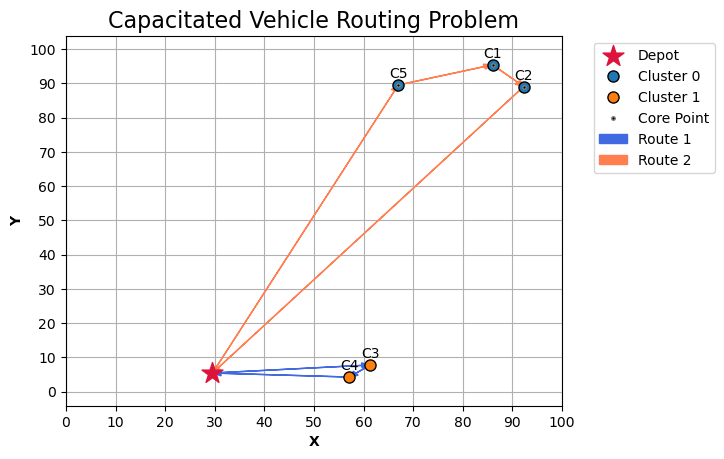

,X,Y,Vehicle Capacity,Demand,X Mean,Y Mean,X Std,Y Std,X Max,Y Max,X Min,Y Min,Correlation,Skewness X,Skewness Y,Savings,Marginal Cost,Total Cost,Shapley Value
1,86.027966,95.446677,16.0,5.0,72.768039,57.227189,13.892996,41.87684,92.299886,95.446677,57.101808,4.267994,0.802481,0.319153,-0.4015,3.549781,53.092141,290.56169,85.337134
2,92.299886,89.092199,16.0,2.0,72.768039,57.227189,13.892996,41.87684,92.299886,95.446677,57.101808,4.267994,0.802481,0.319153,-0.4015,7.240922,7.240922,290.56169,72.157370
3,61.404822,7.793238,16.0,4.0,72.768039,57.227189,13.892996,41.87684,92.299886,95.446677,57.101808,4.267994,0.802481,0.319153,-0.4015,9.927915,50.239351,290.56169,30.779912
4,57.101808,4.267994,16.0,4.0,72.768039,57.227189,13.892996,41.87684,92.299886,95.446677,57.101808,4.267994,0.802481,0.319153,-0.4015,1.197420,50.739781,290.56169,28.850226
5,67.005710,89.535835,16.0,4.0,72.768039,57.227189,13.892996,41.87684,92.299886,95.446677,57.101808,4.267994,0.802481,0.319153,-0.4015,5.720845,55.263206,290.56169,73.437048


RECOMPUTED STATISTICS:
X mean: 72.76803858760505
Y mean: 57.227188527004955
X std: 13.892995724746854
Y std: 41.87684003721209
X max: 92.29988637475161
Y max: 95.44667738571344
X min: 57.1018081382803
Y min: 4.267993624762911
X skew: 0.3191529982017042
Y skew: -0.40150029390696074
X and Y coordinates correlation: 0.8024812114516274


In [6]:
# Get column names
statistical_features = ["X Mean", "Y Mean", "X Std", "Y Std", "X Max", "Y Max", "X Min", "Y Min", "Correlation", "Skewness X", "Skewness Y"]
cost_features = ["Savings", "Marginal Cost", "Total Cost", "Shapley Value"]

# View instance with optimal tour and display the data frame
plot_instance(coord=coord, sequence=sequence, total_cost=total_cost, x_range=x_range, y_range=y_range, optimization_problem=optimization_problem,
              assignments=assignments, core_point_indices=core_point_indices, plot_sequence=True, print_sequence=True)
display(instance_df[instance_features[2:6] + statistical_features + cost_features])

# Recompute statistics
print("RECOMPUTED STATISTICS:")
statistics = [np.mean, np.std, np.max, np.min, skew]
for statistic in statistics:
    for column in ["X", "Y"]:
        print("{} {}: {}".format(column, str(statistic.__name__), statistic((instance_df[column]))))

print("X and Y coordinates correlation:", np.corrcoef(instance_df["X"], instance_df["Y"])[0, 1])

**Ratio features**

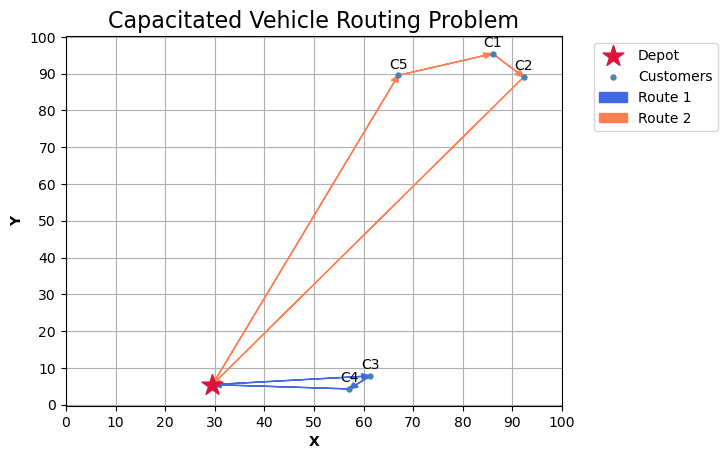

,X,Y,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,4th CCD,5th CCD,6th CCD,7th CCD,...,Centroid Distance To Depot,Distance To Closest Other Cluster,Distance To Closest Other Centroid,Cluster Area,Cluster Density,Savings,Marginal Cost,Demand,Cluster Demand,Cluster Demand Proportion
1,86.027966,95.446677,106.260742,8.928403,19.919445,91.046278,95.657070,100000.0,100000.0,100000.0,...,100.548804,91.046278,93.338706,502.494082,0.005970,3.549781,53.092141,5.0,11.0,0.454545
2,92.299886,89.092199,104.573261,8.928403,25.298066,86.971410,91.837087,100000.0,100000.0,100000.0,...,100.548804,86.971410,89.394086,502.494082,0.005970,7.240922,7.240922,2.0,11.0,0.181818
3,61.404822,7.793238,31.940509,5.562668,81.934255,86.971410,91.046278,100000.0,100000.0,100000.0,...,29.707907,81.934255,86.012613,14.542375,0.137529,9.927915,50.239351,4.0,8.0,0.500000
4,57.101808,4.267994,27.575262,5.562668,85.841086,91.837087,95.657070,100000.0,100000.0,100000.0,...,29.707907,85.841086,90.518604,14.542375,0.137529,1.197420,50.739781,4.0,8.0,0.500000
5,67.005710,89.535835,92.062143,19.919445,25.298066,81.934255,85.841086,100000.0,100000.0,100000.0,...,100.548804,81.934255,83.864302,502.494082,0.005970,5.720845,55.263206,4.0,11.0,0.363636


,X,Y,Depot Distance Ratio,Closest Customer Distance (CCD) Ratio,2nd CCD Ratio,3rd CCD Ratio,4th CCD Ratio,5th CCD Ratio,6th CCD Ratio,7th CCD Ratio,...,Centroid Distance To Depot Ratio,Distance To Closest Other Cluster Ratio,Distance To Closest Other Centroid Ratio,Cluster Area Ratio,Cluster Density Ratio,Savings Ratio,Marginal Cost Ratio,Demand Ratio,Cluster Demand Ratio,Cluster Demand Proportion Ratio
1,86.027966,95.446677,1.466022,0.912895,0.417965,1.037540,1.039664,1.0,1.0,1.0,...,1.392403,1.064303,1.053179,1.635119,0.101892,0.642218,1.225720,1.315789,1.122449,1.136364
2,92.299886,89.092199,1.442740,0.912895,0.530823,0.991104,0.998145,1.0,1.0,1.0,...,1.392403,1.016669,1.008670,1.635119,0.101892,1.310010,0.167169,0.526316,1.122449,0.454545
3,61.404822,7.793238,0.440666,0.568762,1.719206,0.991104,0.989550,1.0,1.0,1.0,...,0.411396,0.957786,0.970516,0.047321,2.347162,1.796135,1.159858,1.052632,0.816327,1.250000
4,57.101808,4.267994,0.380441,0.568762,1.801182,1.046552,1.039664,1.0,1.0,1.0,...,0.411396,1.003456,1.021359,0.047321,2.347162,0.216634,1.171411,1.052632,0.816327,1.250000
5,67.005710,89.535835,1.270131,2.036687,0.530823,0.933701,0.932977,1.0,1.0,1.0,...,1.392403,0.957786,0.946276,1.635119,0.101892,1.035002,1.275842,1.052632,1.122449,0.909091


In [7]:
# Get column names
ratio_features = ["Depot Distance", "Closest Customer Distance (CCD)", "2nd CCD", "3rd CCD", "4th CCD", "5th CCD", "6th CCD", "7th CCD", "8th CCD", "9th CCD", "10th CCD", 
                  "Mean Distance To Other Customers", "Gravity Center Distance", "Centroid Distance", "Centroid Distance To Depot", "Distance To Closest Other Cluster", 
                  "Distance To Closest Other Centroid", "Cluster Area", "Cluster Density", "Savings", "Marginal Cost"]

if (optimization_problem == "CVRP"): ratio_features += ["Demand", "Cluster Demand", "Cluster Demand Proportion"]

# View instance with optimal tour and display the data frame
plot_instance(coord=coord, sequence=sequence, total_cost=total_cost, x_range=x_range, y_range=y_range, optimization_problem=optimization_problem, 
         assignments=None, core_point_indices=None, plot_sequence=True)
display(instance_df[["X", "Y"] + ratio_features])
display(instance_df[["X", "Y"] + [i + " Ratio" for i in ratio_features]])

In [11]:
feature = "Cluster Demand"
mean = np.mean(instance_df[feature])
ratio = np.array(instance_df[feature] / mean)
for i in range(num_customers): print("Customer {}: {} / {} = {}".format(i+1, instance_df.iloc[i][feature], mean, ratio[i]))

Customer 1: 11.0 / 9.8 = 1.1224489795918366
Customer 2: 11.0 / 9.8 = 1.1224489795918366
Customer 3: 8.0 / 9.8 = 0.8163265306122448
Customer 4: 8.0 / 9.8 = 0.8163265306122448
Customer 5: 11.0 / 9.8 = 1.1224489795918366
